Проект посвящен предсказанию года выпуска песни, ориентируясь на [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import sklearn

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-12 20:34:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [          <=>       ] 201.24M  44.2MB/s    in 4.9s    

2023-10-12 20:34:05 (41.2 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Скейлим данные для для корректной работы

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
print("Количество уникальных годов песен: ", df[0].nunique())

Количество уникальных годов песен:  89


Смотрим как справляется линейная регрессия


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Фиксируем seed для воспроизводимости экспериментов

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(random_state=set_random_seed(42))
model.fit(X_train, y_train)

rmse_for_model = np.sqrt(mean_squared_error(model.predict(X_test), y_test))

print(rmse_for_model)

In [ ]:
best_constant_prediction = np.mean(y_train)
print("best_constant_prediction is: ", best_constant_prediction)

print('Значение при наилучшем константном прогнозе:', np.mean((y_test - best_constant_prediction)) ** 2)

print('Kачество при наилучшем константном прогнозе RMSE:', np.sqrt(mean_squared_error(y_test, [best_constant_prediction] * len(y_test))))

best_constant_prediction is:  1998.3860949074324
Значение при наилучшем константном прогнозе: 0.01202605529819764
Kачество при наилучшем константном прогнозе RMSE: 10.85246390513634


Готовим данные для обучения нейросети

In [ ]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

Изучим распределение данных

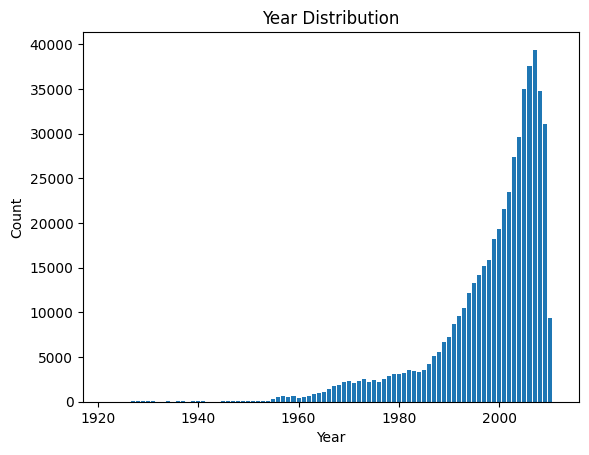

In [ ]:
class_counts = df[0].value_counts()

plt.bar(class_counts.index, class_counts.values)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution')
plt.show()

Используем ядровой скейлинг

In [ ]:
from sklearn.preprocessing import RobustScaler

df = df.fillna(df.mean())

X_val = RobustScaler().fit_transform(pd.DataFrame(df.iloc[:, 1:].values))


In [ ]:
def y_scaler(y):
    return (y - int(pd.DataFrame(df.iloc[:, 0].values).min())) / (int(pd.DataFrame(df.iloc[:, 0].values).max()) - int(pd.DataFrame(df.iloc[:, 0].values).min()))

def y_scaler_inverse(y):
    return (y * int((pd.DataFrame(df.iloc[:, 0].values).max()) - int(pd.DataFrame(df.iloc[:, 0].values).min())) + int(pd.DataFrame(df.iloc[:, 0].values).min()))

y_val = y_scaler(pd.DataFrame(df.iloc[:, 0].values))

In [ ]:
x_tr, x_test, y_tr, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

y_tr_np = y_tr.values
y_test_np = y_test.values

x_tr = torch.from_numpy(x_tr).float()
y_tr = torch.from_numpy(y_tr_np).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test_np).float()

  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 1, Loss: 10.137026368852538


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.941984300435701


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 2, Loss: 9.553081658861162


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.874566964925446


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 3, Loss: 9.315459690704282


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.821287823710628


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 4, Loss: 9.180241559755727


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.798499195965674


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 5, Loss: 9.08909524845857


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.779069822007331


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 6, Loss: 9.022254151008584


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.764023243632293


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 7, Loss: 8.97041567414017


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.748583747578316


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 8, Loss: 8.929234136940318


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.731152656532469


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 9, Loss: 8.894841120903184


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.722120826392988


  0%|          | 0/5636 [00:00<?, ?it/s]

Epoch 10, Loss: 8.865052244043925


  0%|          | 0/2415 [00:00<?, ?it/s]

Test RMSE: 8.709235621485897


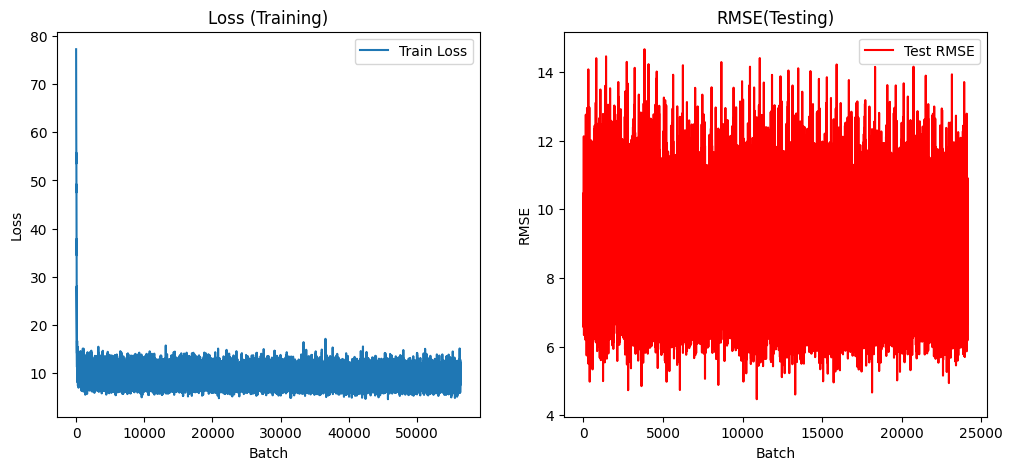

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def RMSE(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2) ** 0.5


class FeedNetBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4):
        super(FeedNetBatchNorm, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.ln1 = nn.LayerNorm(hidden_dim1)
        self.hidden_layer1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.ln2 = nn.LayerNorm(hidden_dim2)
        self.hidden_layer2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.ln3 = nn.LayerNorm(hidden_dim3)
        self.hidden_layer3 = nn.Linear(hidden_dim3, hidden_dim4)
        self.bn4 = nn.BatchNorm1d(hidden_dim4)
        self.ln4 = nn.LayerNorm(hidden_dim4)
        self.hidden_layer4 = nn.Linear(hidden_dim4, 1)


    def forward(self, x):
        x = self.input_layer(x)
        x = self.bn1(x)
        x = self.ln1(x)
        x = torch.tanh(x)
        x = self.hidden_layer1(x)
        x = self.bn2(x)
        x = self.ln2(x)
        x = torch.tanh(x)
        x = self.hidden_layer2(x)
        x = self.bn3(x)
        x = self.ln3(x)
        x = torch.tanh(x)
        x = self.hidden_layer3(x)
        x = self.bn4(x)
        x = self.ln4(x)
        x = torch.tanh(x)
        x = self.hidden_layer4(x)
        return x


input_dim = 90
hidden_dim1 = 32
hidden_dim2 = 64
hidden_dim3 = 128
hidden_dim4 = 16

model = FeedNetBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4)

train_dataloader = DataLoader(TensorDataset(x_tr, y_tr), batch_size=64, shuffle=True, num_workers=1, drop_last=True)

test_dataloader = DataLoader(TensorDataset(x_test, y_test), batch_size=64, shuffle=False, num_workers=1, drop_last=True)

criterion = RMSE
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loss = []
test_loss = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in tqdm(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss_train = criterion(y_scaler_inverse(y_pred), y_scaler_inverse(batch_y))  # RMSE
        train_loss.append(loss_train.item())
        loss_train.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {np.mean(train_loss)}")

    model.eval()
    with torch.no_grad():

        for batch_X, batch_y in tqdm(test_dataloader):
            y_pred = model(batch_X)
            loss_test = RMSE(y_scaler_inverse(y_pred), y_scaler_inverse(batch_y))  # RMSE
            test_loss.append(loss_test.item())

    print(f"Test RMSE: {np.mean(test_loss)}")

plt.figure(figsize=(12, 5))

# График лосса
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss (Training)')

# График RMSE
plt.subplot(1, 2, 2)
plt.plot(range(len(test_loss)), test_loss, label='Test RMSE', color='red')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE(Testing)')

plt.show()


In [ ]:
import itertools


def create_and_train_model(hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, optimizer, learning_rate, criterion, train_loader, test_loader, input_dim=90):
    model = FeedNetBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4)

    optimizer = optimizer(model.parameters(), lr=learning_rate)

    num_epochs = 2
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in tqdm(train_loader):
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_scaler_inverse(y_pred), y_scaler_inverse(batch_y))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader):
                y_pred = model(batch_X)
                loss = criterion(y_scaler_inverse(y_pred), y_scaler_inverse(batch_y))
                test_loss += loss.item()
            test_loss /= len(test_loader)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, train_loss, test_loss


hidden_dim_options = [(32, 64, 128), (32, 64, 16), (8, 32, 16), (32, 8, 16)]
optimizer_options = [optim.Adam, optim.RMSprop]
learning_rate_options = [0.001, 0.01]
criterion = [RMSE, nn.MSELoss, nn.L1Loss]

best_rmse = 8.85
best_model = None

for hidden_dim_tuple in itertools.product(*hidden_dim_options):

    hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4 = hidden_dim_tuple

    model, train_loss, test_loss = create_and_train_model(hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, optimizer=optim.Adam, learning_rate=0.001, criterion=RMSE, train_loader=train_dataloader, test_loader=test_dataloader)


    if test_loss <= best_rmse:
        best_rmse = test_loss
        best_model = model
        print(best_model)

print("Best RMSE:", best_rmse)
print("Best model configuration:")
print(best_model)

(32, 32, 8, 32, 8)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.5701, Test Loss: 9.0142


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.0131, Test Loss: 8.8778
(32, 32, 8, 32, 16)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 9.8791, Test Loss: 9.0056


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 8.9891, Test Loss: 8.8880
(32, 32, 8, 8, 8)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.0155, Test Loss: 9.1285


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.0189, Test Loss: 8.8602
(32, 32, 8, 8, 16)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.3370, Test Loss: 9.1032


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.0346, Test Loss: 8.8883
(32, 32, 8, 16, 8)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 9.7742, Test Loss: 9.0405


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 8.9539, Test Loss: 8.8047
FeedNetBatchNorm(
  (input_layer): Linear(in_features=90, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (hidden_layer1): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (hidden_layer2): Linear(in_features=32, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (hidden_layer3): Linear(in_features=8, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (hidden_layer4): Linear(in_features=16, out_features=8,

  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.3028, Test Loss: 8.9553


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.0430, Test Loss: 9.0496
(32, 32, 32, 32, 8)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.2715, Test Loss: 8.9678


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 8.9592, Test Loss: 8.8379
(32, 32, 32, 32, 16)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 10.3723, Test Loss: 8.9517


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.0186, Test Loss: 8.8204
(32, 32, 32, 8, 8)


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 1, Train Loss: 11.2246, Test Loss: 9.1712


  0%|          | 0/5636 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Epoch 2, Train Loss: 9.1186, Test Loss: 8.8519
(32, 32, 32, 8, 16)


  0%|          | 0/5636 [00:00<?, ?it/s]

KeyboardInterrupt: ignored